# Boosted Trees: AdaBoost

In this notebook, we will implement the AdaBoost algorithm.

This includes the following steps:
1. Understand classifier weights and sample weight updating
1. Generate data and estimate `sklearn` AdaBoost
1. Manually implement AdaBoost
1. Study AdaBoost learning progress "by iteration"

## Background

AdaBoost stands for Adaptive Boosting. AdaBoost uses an ensemble of (sequential) weak learners (often simple decision trees) to make predictions. Each predictor pays more attention to the instances wrongly predicted by the preceeding trees. This is achieved by changing the weights of training samples, focusing more on difficult patterns in the data. Each learner is assigned a coefficient that determines the predictor’s weight in ensemble. In making the final prediction, the learner's weight depends on its accuracy.

<img src="https://raw.githubusercontent.com/sbstn-gbl/learning-from-big-data/master/source/_static/img/adaboost.png" width="900"/>

In [1]:
import copy
import typing

import common
import graphviz
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sklearn.datasets
import sklearn.ensemble
import sklearn.tree

## Classifier weight

The classifier weight for tree $b$ is calculated based on the error rate $e_b$

$
\quad\alpha_b = \log\left(\displaystyle\frac{1-e_b}{e_b} \right ) \big/ 2
$

Weighting by $\alpha$ in the ensemble classifier:

1. Good classifiers are given (exponentially) more weight
2. Classifier with 50% accuracy is no better than random guessing, so we ignore it
3. Bad classifier are given a negative weight, so whatever that classifier says, do the opposite ;)

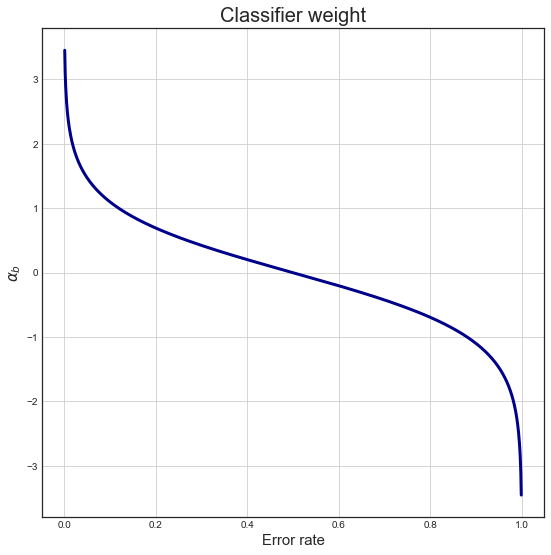

In [2]:
error = np.arange(0.001, 1, 0.001)
alpha = np.log((1 - error) / error) / 2
plt.plot(error, alpha, c="darkblue", lw=3)
plt.title("Classifier weight")
plt.xlabel("Error rate")
plt.ylabel(r"$\alpha_b$")
plt.show()

## Updating sample weights

Update equation for sample weights

$
\quad w_i \leftarrow w_i \exp\left\{ -\alpha_b \; y_i \mathcal{M}_b(x_i) \big) \right\}
$

Note:

1. A "good" classifier has an error rate below 50%, i.e., an accuracy above 50%
1. More weight is put on a sample if the scaling factor is > 1, i.e., the exponent $-\alpha_b \; y_i \mathcal{M}_b(x_i)$ is larger $0$
    1. For a "good" classifier we put more weight on incorrectly predicted samples
    1. For a "bad" classifier we put more weight on correctly predicted samples

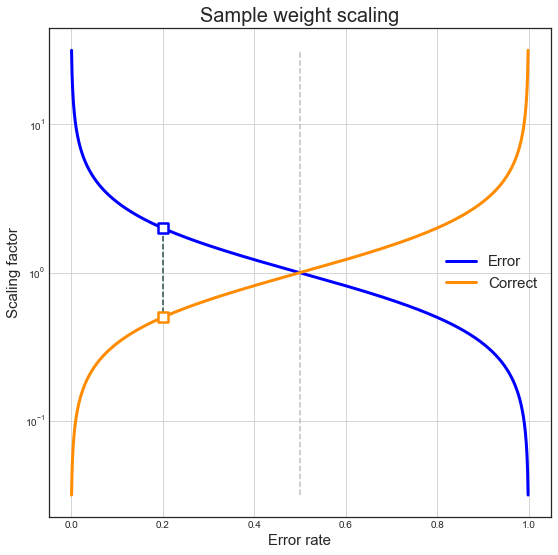

In [3]:
# Note the log scale for `y`

# error rate of coin flip
plt.vlines(
    0.5, min(np.exp(alpha)), max(np.exp(alpha)), linestyles="--", color="silver"
)

# scaling factor for incorrectly predicted samples
plt.plot(error, np.exp(-alpha * -1), c="blue", lw=3, label="Error")

# scaling factor for correctly predicted samples
plt.plot(error, np.exp(-alpha * 1), c="darkorange", lw=3, label="Correct")

# example: error rate of 0.2
error_i = .2
alpha_i = np.log((1 - error_i) / error_i) / 2
scaling_i_cor = np.exp(-alpha_i)
scaling_i_err = np.exp(alpha_i)
plt.vlines(error_i, scaling_i_err, scaling_i_cor, linestyles="--", color="darkslategrey")
plt.scatter(error_i, scaling_i_err, s=100, zorder=100, marker="s", facecolors="w", edgecolors="blue", linewidth=2.5)
plt.scatter(error_i, scaling_i_cor, s=100, zorder=100, marker="s", facecolors="w", edgecolors="darkorange", linewidth=2.5)

# style plot
plt.yscale("log")
plt.title("Sample weight scaling")
plt.xlabel("Error rate")
plt.ylabel("Scaling factor")
plt.legend()
plt.show()

<br> 

## Generate data

In [4]:
def generate_data(n: int, seed: int) -> (np.ndarray, np.ndarray):
    np.random.seed(seed)
    X, y = sklearn.datasets.make_gaussian_quantiles(
        n_samples=n, n_features=2, n_classes=2
    )
    y = y * 2 - 1  # transform to {-1, 1}
    return X, y

In [5]:
X, y = generate_data(n=10, seed=10)
X, y

(array([[ 0.00429143, -0.17460021],
        [ 0.43302619,  1.20303737],
        [-0.96506567,  1.02827408],
        [ 0.22863013,  0.44513761],
        [ 0.62133597, -0.72008556],
        [-1.13660221,  0.13513688],
        [-1.54540029, -0.00838385],
        [ 1.3315865 ,  0.71527897],
        [ 0.26551159,  0.10854853],
        [ 1.484537  , -1.07980489]]),
 array([-1,  1,  1, -1, -1, -1,  1,  1, -1,  1]))

## Plot data

In [6]:
def plot_adaboost(
    X: np.ndarray,
    y: np.ndarray,
    clf=None,
    sample_weights: typing.Optional[np.ndarray] = None,
    ax: typing.Optional[matplotlib.axes.Axes] = None,
) -> None:

    """
    Based on [1]
    """

    if not ax:
        fig, ax = plt.subplots()

    pad = 1
    x_min, x_max = X[:, 0].min() - pad, X[:, 0].max() + pad
    y_min, y_max = X[:, 1].min() - pad, X[:, 1].max() + pad

    if sample_weights is not None:
        sizes = X.shape[0] * np.array(sample_weights) * 120
    else:
        sizes = np.ones(shape=X.shape[0]) * 120

    if clf:
        plot_step = 0.005
        xx, yy = np.meshgrid(
            np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step)
        )
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
        if np.all(Z == 1):
            cmap_light = matplotlib.colors.ListedColormap(["#FFAAAA", "#FFAAAA"])
        elif np.all(Z == 0):
            cmap_light = matplotlib.colors.ListedColormap(["#AAAAFF", "#AAAAFF"])
        else:
            cmap_light = matplotlib.colors.ListedColormap(["#AAAAFF", "#FFAAAA"])
        ax.pcolormesh(xx, yy, Z, cmap=cmap_light)

    ax.scatter(*X[y == 1].T, s=sizes[y == 1], marker="D", color="red")
    ax.scatter(*X[y == -1].T, s=sizes[y == -1], marker="^", c="blue")

    ax.set_xlim(x_min + 0.5, x_max - 0.5)
    ax.set_ylim(y_min + 0.5, y_max - 0.5)
    ax.set_xlabel("Feature 1")
    ax.set_ylabel("Feature 2")

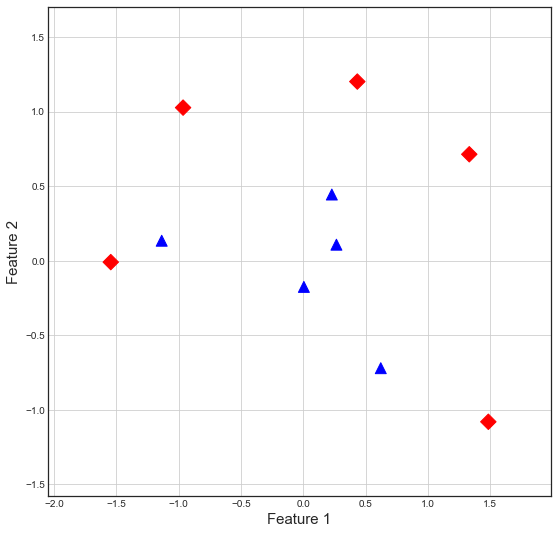

In [7]:
plot_adaboost(X, y)

<br> 

## Reference solution in `sklearn`

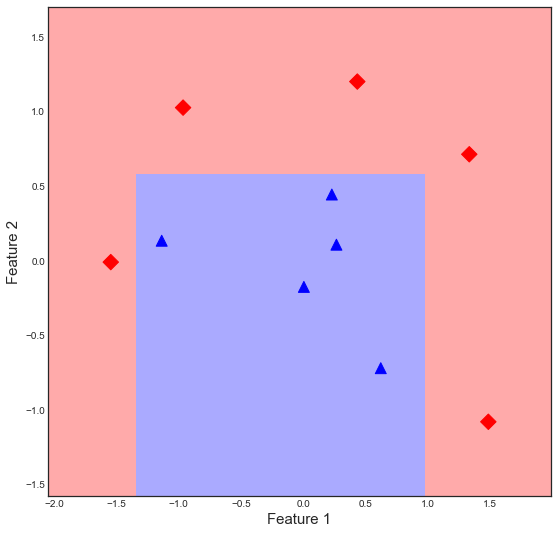

In [8]:
sklearn_adaboost = sklearn.ensemble.AdaBoostClassifier(
    n_estimators=10, algorithm="SAMME"
)

sklearn_adaboost.fit(X, y)

plot_adaboost(X, y, sklearn_adaboost)

<br> 

## Some first steps

### Init

In [9]:
n = X.shape[0]
t = -1
iters = 10
sample_weights = np.zeros(shape=(iters, n))
stump_weights = np.zeros(shape=iters)
errors = np.zeros(shape=iters)

In [10]:
sample_weights[0] = np.ones(shape=n) / n
sample_weights

array([[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ]])

### Loop over iterations

#### update iteration counter

In [11]:
t += 1
t

0

#### sample weights in current iteration

In [12]:
sample_weights[t]

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

#### train stump and make predictions

In [13]:
stump = sklearn.tree.DecisionTreeClassifier(max_depth=1, max_leaf_nodes=2)
stump = stump.fit(X, y, sample_weight=sample_weights[t])
stump_pred = stump.predict(X)
y, stump_pred

(array([-1,  1,  1, -1, -1, -1,  1,  1, -1,  1]),
 array([-1,  1,  1, -1, -1, -1, -1,  1, -1, -1]))

#### Prediction errors

In [14]:
y * stump_pred

array([ 1,  1,  1,  1,  1,  1, -1,  1,  1, -1])

#### Error rate

In [15]:
err = sample_weights[t][(stump_pred != y)].sum()
err

0.2

#### Classifier weight

In [16]:
stump_weight = np.log((1 - err) / err) / 2
stump_weight

0.6931471805599453

#### Update sample weights

In [17]:
new_sample_weights = sample_weights[t] * np.exp(-stump_weight * y * stump_pred)
new_sample_weights /= new_sample_weights.sum()
sample_weights[t + 1] = new_sample_weights
new_sample_weights

array([0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.25  , 0.0625,
       0.0625, 0.25  ])

#### Check that new weights sum up to 1

In [18]:
assert sum(new_sample_weights) == 1

#### Update ratio (t -> t+1)

In [19]:
sample_weights[t + 1] / sample_weights[t]

array([0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 2.5  , 0.625, 0.625,
       2.5  ])

<br> 

## Two different formal representations of the target variable ... 

... yield the same results

Note the small differences in the calculation of $\alpha_b$ and the sample weight scaling factors

In [20]:
N = 10

In [21]:
np.random.seed(2)

In [22]:
w_i = np.ones(N) / N
w_i

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

### $y \in \{0, 1\}$

In [23]:
y_1 = np.random.choice([0, 1], N)
yhat_1 = np.random.choice([0, 1], N)
error_1 = (y_1 != yhat_1).astype(int)
y_1, yhat_1, error_1

(array([0, 1, 1, 0, 0, 1, 0, 1, 0, 1]),
 array([0, 1, 1, 1, 1, 1, 1, 1, 0, 0]),
 array([0, 0, 0, 1, 1, 0, 1, 0, 0, 1]))

In [24]:
error_rate = np.mean(y_1 != yhat_1)
error_rate

0.4

In [25]:
def update_weights_1(x, e, er):
    alpha = np.log((1 - er) / er)
    out = x * np.exp(alpha * e)
    out /= sum(out)
    return out

In [26]:
update_weights_1(w_i, error_1, error_rate)

array([0.08333333, 0.08333333, 0.08333333, 0.125     , 0.125     ,
       0.08333333, 0.125     , 0.08333333, 0.08333333, 0.125     ])

### $y \in \{-1, 1\}$

In [27]:
y_2 = 2 * y_1 - 1
yhat_2 = 2 * yhat_1 - 1
y_2, yhat_2

(array([-1,  1,  1, -1, -1,  1, -1,  1, -1,  1]),
 array([-1,  1,  1,  1,  1,  1,  1,  1, -1, -1]))

In [28]:
def update_weights_2(x, y, yhat, er):
    alpha = np.log((1 - er) / er) / 2
    out = x * np.exp(-alpha * y * yhat)
    out /= sum(out)
    return out

In [29]:
update_weights_2(w_i, y_2, yhat_2, error_rate)

array([0.08333333, 0.08333333, 0.08333333, 0.125     , 0.125     ,
       0.08333333, 0.125     , 0.08333333, 0.08333333, 0.125     ])

<br> 

## Manual implementation

In [30]:
class AdaBoost:
    """
    Based on [1]
    """

    def __init__(self):
        self.stumps = None
        self.stump_weights = None  # alpha_b
        self.errors = None
        self.sample_weights = None

    def fit(self, X: np.ndarray, y: np.ndarray, iters: int):

        # init
        n = X.shape[0]
        self.sample_weights = np.zeros(shape=(iters, n))
        self.stumps = np.zeros(shape=iters, dtype=object)
        self.alphas = np.zeros(shape=iters)
        self.errors = np.zeros(shape=iters)
        sample_weights = np.ones(shape=n) / n  # uniform weights for training samples

        # training loop
        for t in range(iters):

            # store updated weights
            self.sample_weights[t] = sample_weights

            # decision stump (our weak learner)
            decision_stump_t = sklearn.tree.DecisionTreeClassifier(
                max_depth=1, max_leaf_nodes=2
            )
            decision_stump_t.fit(X, y, sample_weight=sample_weights)
            prediction_t = decision_stump_t.predict(X)

            # calculate error rate
            error_rate = sample_weights[(prediction_t != y)].sum()

            # calculate model weight
            alpha_t = np.log((1 - error_rate) / error_rate) / 2

            # update weights
            sample_weights *= np.exp(-alpha_t * y * prediction_t)
            sample_weights /= sample_weights.sum()

            # save results of iteration
            self.stumps[t] = decision_stump_t
            self.alphas[t] = alpha_t
            self.errors[t] = error_rate

        return self

    def predict(self, X: np.ndarray):
        stump_preds = np.array([stump.predict(X) for stump in self.stumps])
        return np.sign(np.dot(self.alphas, stump_preds))

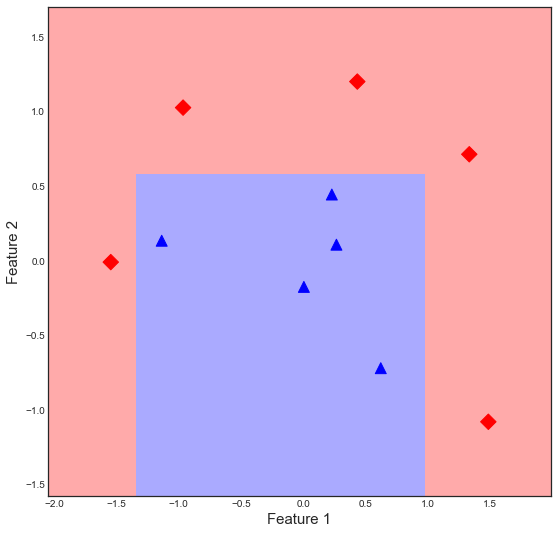

In [31]:
adaboost = AdaBoost().fit(X, y, iters=10)
plot_adaboost(X, y, adaboost)

### Visualization by iteration

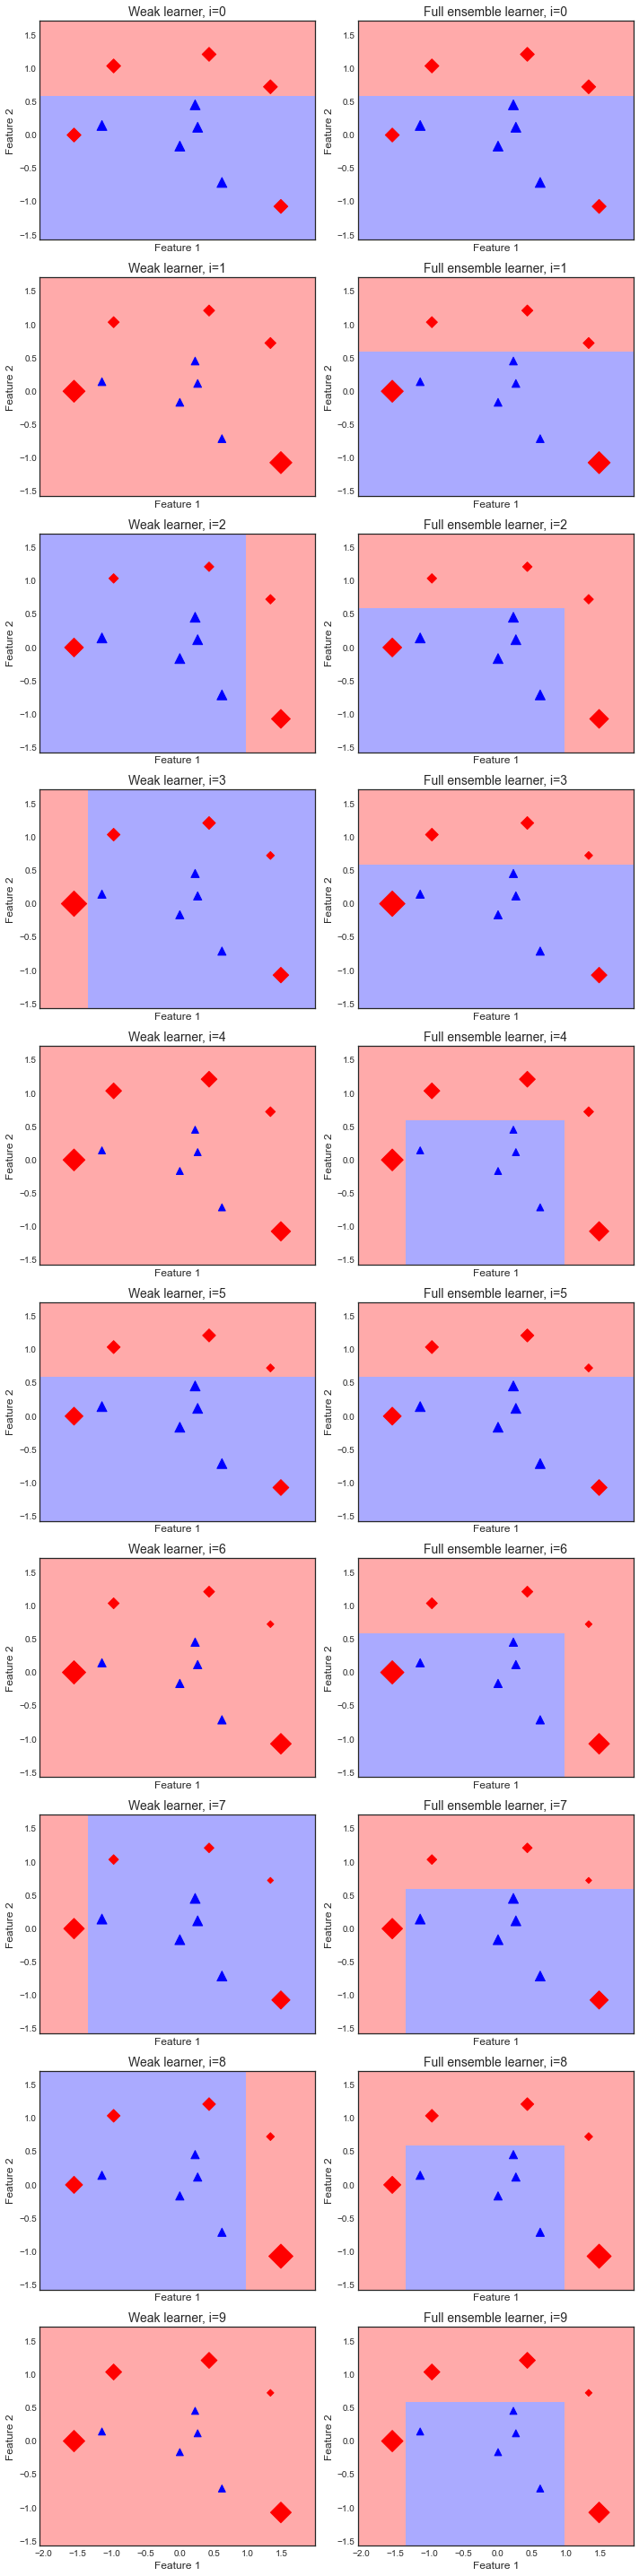

In [32]:
# Init
plt.rcParams.update(
    {
        "axes.titlesize": 14,
        "axes.labelsize": 12,
    }
)
I = 10
fig, axes = plt.subplots(nrows=I, ncols=2, sharex=True, figsize=(I, iters * 4))

# Train model
adaboost = AdaBoost().fit(X, y, iters=I)

# Plot results for each iteration
for i in range(I):
    ax1, ax2 = axes[i]

    # Plot weak learner
    plot_adaboost(
        X,
        y,
        adaboost.stumps[i],
        sample_weights=adaboost.sample_weights[i],
        ax=ax1,
    )

    # Plot strong learner
    adaboost_i = copy.deepcopy(adaboost)
    adaboost_i.stumps = adaboost.stumps[: (i + 1)]
    adaboost_i.alphas = adaboost.alphas[: (i + 1)]
    plot_adaboost(
        X,
        y,
        adaboost_i,
        sample_weights=adaboost.sample_weights[i],
        ax=ax2,
    )

    # Plot styling
    _ = ax1.set_title(f"Weak learner, i={i}")
    _ = ax2.set_title(f"Full ensemble learner, i={i}")

plt.tight_layout()
plt.show()

#### What happens in iteration 1?

- Both leaf nodes predict class 1 (red)
- This is driven by the additional weight put on class 1 samples that we misclassified in iteration 0
- So despite the fact that the left leaf node contains more observations for class 0, class 1 is predicted

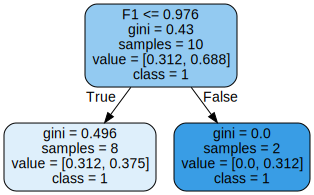

In [33]:
dot_data = sklearn.tree.export_graphviz(
    adaboost.stumps[1],
    out_file=None,
    feature_names=["F1", "F2"],
    class_names=["0", "1"],
    filled=True,
    rounded=True,
)
graphviz.Source(dot_data)

<br>
<br>
&mdash; <br>
Sebastian Gabel <br>
`Learning from Big Data`, Module 2, Lecture 07 <br>
2021/22 <br>

<br>

[1] Based on [this source](https://geoffruddock.com/adaboost-from-scratch-in-python/)